Copyright (C) 2023 by The RAND Corporation  
See LICENSE and README.md for information on usage and licensing  

# Karzas-Latter-Seiler Model of EMP

This notebook implements the Seiler model, which is a simplified form of the well-known Karzas-Latter treatment of the Electromagnetic Pulse (EMP) phenomena. The original reference is:

    Seiler Jr, Louis W. A calculational model for high altitude EMP. AIR FORCE INST OF TECH WRIGHT-PATTERSON AFB OH SCHOOL OF ENGINEERING, 1975.
    
- The Seiler report is publicly available through DTIC: [link](https://apps.dtic.mil/sti/pdfs/ADA009208.pdf)
- The published KL report is available here: [link](https://journals.aps.org/pr/abstract/10.1103/PhysRev.137.B1369) behind a paywall
- A publicly-avaiable draft version of the KL report is also available through DTIC: [link](https://apps.dtic.mil/sti/pdfs/AD0607788.pdf)

In [1]:
## imports
import os
from tqdm import tqdm
import pickle 
import numpy as np
import folium
from folium import Map
from folium.plugins import HeatMap
import branca
import pandas as pd
import geojsoncontour
import matplotlib.pyplot as plt
import matplotlib 
from cycler import cycler
import io
from PIL import Image

## my imports
import emp
import region_scan
import HOB_yield_scan


## plot settings
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['lines.linewidth'] = 2
plt.rc('font', family='serif',size=16)
matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=16)
matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8'])
matplotlib.rcParams.update({"axes.grid":True,
                            "grid.alpha":0.75,
                            "grid.linewidth":0.5})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## PRNG seed
rng = np.random.default_rng(123)

In [2]:
## DELETE THIS EVENTUALLY

## re-import, used for iterative development
import importlib
import HOB_yield_scan
importlib.reload(region_scan)
importlib.reload(HOB_yield_scan)
importlib.reload(emp)

<module 'emp' from '/Users/hartnett/Desktop/EMP/karzas-latter-seiler/emp.py'>

In [3]:
## create a figures folder
if not os.path.exists('figures'):
    os.makedirs('figures')

## create a data folder
if not os.path.exists('data'):
    os.makedirs('data')

## The Model

In [4]:
## instantiate an EMP model object
model = emp.EMPMODEL()

Compute the dimensionless quantity $\omega T$ to assess the validity of the Seiler approximation:

In [5]:
print('value at lower boundary of absorption layer: %.4f' % (1e-9 * model.omega * model.TCompton(model.rmax)))
print('value at upper boundary of absorption layer: %.4f' % (1e-9 * model.omega * model.TCompton(model.rmin)))

value at lower boundary of absorption layer: 0.0170
value at upper boundary of absorption layer: 0.0648


Inspect the many functions that enter into the model.

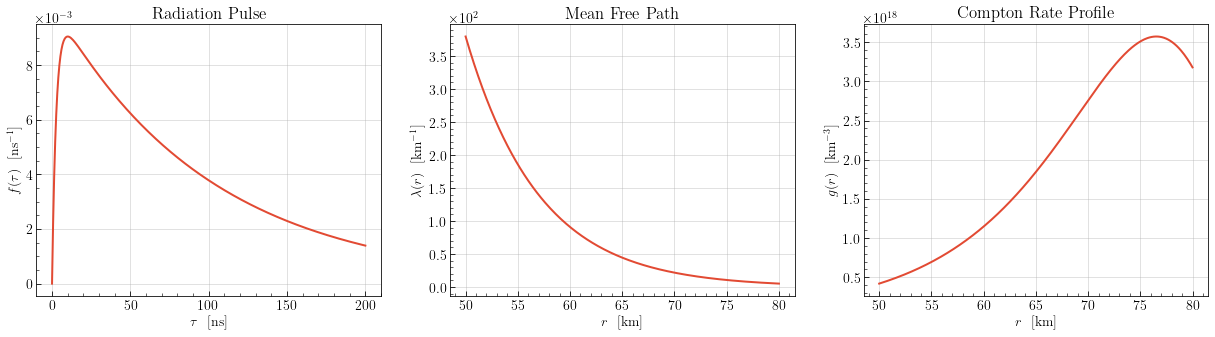

In [6]:
t_list = np.linspace(0, 200, 300)
r_list = np.linspace(model.rmin, model.rmax, 300)

fig, ax = plt.subplots(1, 3, figsize=(3*7,5))

ax[0].set_title('Radiation Pulse')
ax[0].plot(t_list, model.f_pulse(t_list))
ax[0].set_xlabel(r'$\tau$ \ [ns]')
ax[0].set_ylabel(r'$f(\tau)$ \ [ns$^{-1}$]')
ax[0].minorticks_on()
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax[1].set_title('Mean Free Path')
ax[1].plot(r_list, model.mean_free_path(r_list))
ax[1].set_xlabel(r'$r$ \ [km]')
ax[1].set_ylabel(r'$\lambda(r)$ \ [km$^{-1}$]')
ax[1].minorticks_on()
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax[2].set_title('Compton Rate Profile')
ax[2].plot(r_list, model.gCompton(r_list))
ax[2].set_xlabel(r'$r$ \ [km]')
ax[2].set_ylabel(r'$g(r)$ \ [km$^{-3}$]')
ax[2].minorticks_on()
ax[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.savefig('figures/MFP_and_ComptonRate.pdf', bbox_inches='tight')
plt.show()

Next, solve the model for a single line-of-sight integration and compare with the digitized results from Seiler.
- Ideally, the model output would agree with the HAEMP data. There are a few implementation details that were not clear from the Seiler report; perhaps these could be the source of the discrepancy. These include the Compton lifetime $T$, stopping distance $R$, and the electron collision frequency.

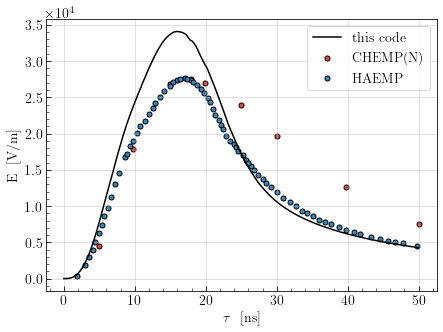

In [7]:
## agreement can be improved by changing r value for E(r) input to nu calculator
model = emp.EMPMODEL(Compton_KE=0.75)
sol = model.solver(np.linspace(0, 50, 200))

## load the digitized data from Seiler
df_CHEMP = pd.read_csv("Seiler Digitized Data/Fig5_CHEMP(N).csv", header=None, names=['t', 'E'])
df_HAEMP = pd.read_csv("Seiler Digitized Data/Fig5_HAEMP.csv", header=None, names=['t', 'E'])

## plot
fig, ax = plt.subplots(1, figsize=(7,5))
ax.plot(sol['tlist'], sol['E_norm_at_ground'], '-', color='k', label='this code', linewidth=1.5, markersize=2)
ax.scatter(df_CHEMP['t'], df_CHEMP['E'], label='CHEMP(N)', s=25, edgecolor='k')
ax.scatter(df_HAEMP['t'], df_HAEMP['E'], label='HAEMP', s=25, edgecolor='k')
ax.set_xlabel(r'$\tau$ \ [ns]')
ax.set_ylabel('E \ [V/m]')
ax.legend()
ax.minorticks_on()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('figures/seiler_comparison.pdf', bbox_inches='tight')
plt.show()

Add the $\gamma$-ray pulse to the plot to compare the time-dependence of the $\gamma$-rays and the EMP.

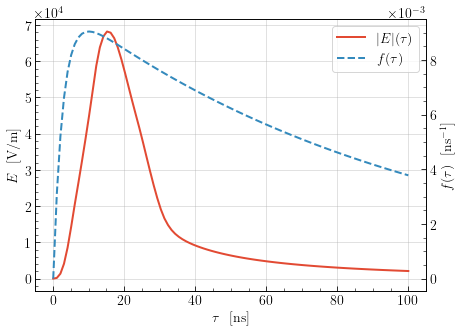

In [8]:
model = emp.EMPMODEL()
sol = model.solver(np.linspace(0, 100, 100))

## plot
fig, ax = plt.subplots(1, figsize=(7,5))
ax2 = ax.twinx()
#ax.grid(color='k')
#ax.grid(False)#, color=colors[0])
ax2.grid(False)#, color=colors[1])

lns0 = ax.plot(sol['tlist'], sol['E_norm_at_ground'], label=r'$|E|(\tau)$', color=colors[0])
lns1 = ax2.plot(sol['tlist'], model.f_pulse(sol['tlist']), label=r'$f(\tau)$', color=colors[1], linestyle='--')

lns = lns0 + lns1
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.set_xlabel(r'$\tau$ \ [ns]')
ax.set_ylabel(r'$E$ \ [V/m]')#, color=colors[0])
ax2.set_ylabel(r'$f(\tau)$ \ [ns$^{-1}$]')#, color=colors[1])

ax.minorticks_on()
ax2.minorticks_on()

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.savefig('figures/EMP_and_gamma_pulse.pdf', bbox_inches='tight')
plt.show()

Investigate the effect of changing latitude.

In [33]:
importlib.reload(emp)

## burst coordinates 
HOB = 1000
phi_B_g = 39.05 * np.pi/180 #latitude (radians)
lambd_B_g = -95.675 * np.pi/180 #longitude (radians)
emp.check_geo_coords(phi_B_g, lambd_B_g)

## target latitudes
N_pts_phi = 50 #number of latitude grid points
Delta_angle = emp.compute_max_delta_angle_1d(HOB, phi_B_g, lambd_B_g)
phi_T_g_list = phi_B_g + np.linspace(-Delta_angle/2, Delta_angle/2, N_pts_phi)

## scan over target locations
data_dic = {'phi_T_g':[], 'phi_T_m':[], 'A':[], 'theta':[], 'B':[]}
for i in range(len(phi_T_g_list)):

    ## update target coords
    phi_T_g = phi_T_g_list[i]
    lambd_T_g = lambd_B_g
    emp.check_geo_coords(phi_T_g, lambd_T_g)
    phi_T_m, lambd_T_m = emp.geo2mag(phi_T_g, lambd_T_g)

    ## get B-field evaluation point
    phi_S_g, lambd_S_g = emp.get_latlong_midway(HOB, phi_B_g, lambd_B_g, phi_T_g, lambd_T_g)
    phi_S_m, lambd_S_m = emp.geo2mag(phi_S_g, lambd_S_g)

    ## update model params
    A = emp.A_angle_latlong(HOB, phi_B_g, lambd_B_g, phi_S_g, lambd_S_g)
    theta = emp.theta_angle(HOB, phi_B_g, lambd_B_g, phi_S_g, lambd_S_g)
    B = emp.B0 * np.sqrt(1 + 3*np.sin(phi_S_m)**2)
    
    ## store results
    data_dic['phi_T_g'].append(phi_T_g)
    data_dic['A'].append(A)
    data_dic['theta'].append(theta)
    data_dic['B'].append(B)

In [34]:
phi_B_g, lambd_B_g, phi_S_g, lambd_S_g, phi_T_g, lambd_T_g

(0.6815510729037856,
 -1.6698437618455746,
 0.6864468894162687,
 -1.6698437618455746,
 0.8997172294030767,
 -1.6698437618455746)

First, plot the variation of the angles $A$, $\theta$, as well as the $B$-field norm with latitude:

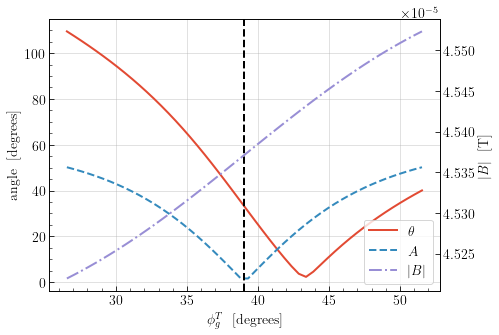

In [35]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax2 = ax.twinx()
ax2.grid(False)#, color=colors[1])

lns0 = ax.plot(180/np.pi * np.asarray(data_dic['phi_T_g']), 180/np.pi * np.asarray(data_dic['theta']), label=r'$\theta$')
lns1 = ax.plot(180/np.pi * np.asarray(data_dic['phi_T_g']), 180/np.pi * np.asarray(data_dic['A']), label=r'$A$', linestyle='--')
lns2 = ax2.plot(180/np.pi * np.asarray(data_dic['phi_T_g']), data_dic['B'], label=r'$|B|$', color=colors[2], linestyle='-.')
lns = lns0 + lns1 + lns2

labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='lower right')

ax.axvline(x=180/np.pi * phi_B_g, color='k', linestyle='--')
ax.set_xlabel(r'$\phi_g^T$ \ [degrees]')
ax.set_ylabel(r' angle \ [degrees]')
ax2.set_ylabel(r' $|B|$ \ [T]')
#ax.set_title(r'Variation of Angles with Latitude')
#ax.legend(fontsize=16)
ax.minorticks_on()
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('figures/angle_variation_with_latitude.pdf', bbox_inches='tight')
plt.show()

## Smile Diagrams

Perform a 2d angular scan over both latitude and longitude for a burst over Kansas.

In [ ]:
## burst coordinates
phi_B_g = 39.05 * np.pi/180 #latitude (radians)
lambd_B_g = -95.675 * np.pi/180 #longitude (radians)

## perform the region scan
topeka_dic = region_scan.region_scan(
    phi_B_g, 
    lambd_B_g, 
    N_pts_phi=100,
    N_pts_lambd=100
    )

## save the result
with open('data/topeka_dic.pkl', 'wb') as f:
    pickle.dump(topeka_dic, f)

In [ ]:
## make a contour plot
x, y, z = region_scan.data_dic_to_xyz(topeka_dic)
contourf = region_scan.contour_plot(x, y, z, save_path='figures/Topeka_smile_contouronly.pdf', grid=True)
contourf = region_scan.contour_plot(x, y, z) # remove the grid

Super-impose this on a map of the Earth

In [ ]:
## convert matplotlib contourf to geojson
## can swap out contourf for contour to get a plot with just the contour lines
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.9)
geojsonf = geojsoncontour.contourf_to_geojson(contourf=contourf)

## set up color map
#cmap = plt.cm.get_cmap('Spectral')
cmap = plt.cm.get_cmap('RdBu_r')

level_spacing = 5e3
levels = [i * level_spacing for i in range(1, 1+int(np.round(np.max(z)/level_spacing)))]
colors = [cmap(x) for x in np.linspace(0, 1, len(levels))]
cm = branca.colormap.LinearColormap(colors, vmin=np.min(levels), vmax=np.max(levels)).to_step(index=levels)

## tile options: "OpenStreetMap", "Stamen Terrain", "Stamen Toner", "Stamen Watercolor", "CartoDB positron", "CartoDB dark_matter"
lat0 = phi_B_g * 180/np.pi
long0 = lambd_B_g * 180/np.pi
geomap = folium.Map([lat0, long0], width=750, height=750, zoom_start=6, tiles="CartoDB positron")

## plot the contour plot ont folium
# see here for style function params: https://leafletjs.com/reference-1.6.0.html#path-option
folium.GeoJson(
    geojsonf,
    style_function=lambda x: {
        'color':     'gray', #x['properties']['stroke'], #color of contour lines
        'weight':    1, #x['properties']['stroke-width'], #thickness of contour lines
        'fillColor': x['properties']['fill'], #color in between contour lines
        'opacity':   1, #opacity of contour lines
        'fillOpacity': 0.5,
    }).add_to(geomap)
 
## add the colormap to the folium map
cm.caption = 'Enorm (V/m)'
geomap.add_child(cm)

#feature_group = folium.FeatureGroup("Locations")
#for lat, lng, name in zip(lat_lst, lng_lst, name_lst):
#    feature_group.add_child(folium.Marker(location=[lat,lon],popup=name))
#map.add_child(feature_group)
geomap.add_child(folium.FeatureGroup("Locations").add_child(folium.Marker(location=[lat0, long0], popup='Ground Zero')))

## convert the geomap to a PIL image
## see: https://stackoverflow.com/questions/40208051/selenium-using-python-geckodriver-executable-needs-to-be-in-path
img_data = geomap._to_png(10)
img = Image.open(io.BytesIO(img_data))

## remove any white-space
## see: https://stackoverflow.com/questions/10965417/how-to-convert-a-numpy-array-to-pil-image-applying-matplotlib-colormap
pix = np.asarray(img)
idx = np.where(pix-255)[0:2] # Drop the color when finding edges
box = list(map(min,idx))[::-1] + list(map(max,idx))[::-1]
region = img.crop(box)
region_pix = np.asarray(region)
img2 = Image.fromarray(region_pix)

## save
img2.convert("RGB").save('figures/Topeka_smile.png', dpi=(900, 900))

## display result
geomap

Next, consider a burst point in the Southern hemisphere, for example Sydney, Australia.

In [ ]:
## burst coordinates
phi_B_g = -33.86 * np.pi/180 #latitude (radians)
lambd_B_g = 151.2093 * np.pi/180 #longitude (radians)

## perform the region scan
sydney_dic = region_scan.region_scan(
    phi_B_g, 
    lambd_B_g, 
    N_pts_phi=100,
    N_pts_lambd=100
    )

## save the result
with open('data/sydney_dic.pkl', 'wb') as f:
    pickle.dump(sydney_dic, f)

In [ ]:
## make a contour plot
x, y, z = region_scan.data_dic_to_xyz(sydney_dic)
contourf = region_scan.contour_plot(x, y, z, save_path='figures/Sydney_smile_contouronly.pdf', grid=True)
contourf = region_scan.contour_plot(x, y, z)

In [ ]:
## convert matplotlib contourf to geojson
## can swap out contourf for contour to get a plot with just the contour lines
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.9)
geojsonf = geojsoncontour.contourf_to_geojson(contourf=contourf)

## set up color map
#cmap = plt.cm.get_cmap('Spectral')
cmap = plt.cm.get_cmap('RdBu_r')

level_spacing = 5e3
levels = [i * level_spacing for i in range(1, 1+int(np.round(np.max(z)/level_spacing)))]
colors = [cmap(x) for x in np.linspace(0, 1, len(levels))]
cm = branca.colormap.LinearColormap(colors, vmin=np.min(levels), vmax=np.max(levels)).to_step(index=levels)

## tile options: "OpenStreetMap", "Stamen Terrain", "Stamen Toner", "Stamen Watercolor", "CartoDB positron", "CartoDB dark_matter"
lat0 = phi_B_g * 180/np.pi
long0 = lambd_B_g * 180/np.pi
geomap = folium.Map([lat0, long0], width=750, height=750, zoom_start=6, tiles="CartoDB positron")

## plot the contour plot ont folium
# see here for style function params: https://leafletjs.com/reference-1.6.0.html#path-option
folium.GeoJson(
    geojsonf,
    style_function=lambda x: {
        'color':     'gray', #x['properties']['stroke'], #color of contour lines
        'weight':    1, #x['properties']['stroke-width'], #thickness of contour lines
        'fillColor': x['properties']['fill'], #color in between contour lines
        'opacity':   1, #opacity of contour lines
        'fillOpacity': 0.5,
    }).add_to(geomap)
 
## add the colormap to the folium map
cm.caption = 'Enorm (V/m)'
geomap.add_child(cm)

#feature_group = folium.FeatureGroup("Locations")
#for lat, lng, name in zip(lat_lst, lng_lst, name_lst):
#    feature_group.add_child(folium.Marker(location=[lat,lon],popup=name))
#map.add_child(feature_group)
geomap.add_child(folium.FeatureGroup("Locations").add_child(folium.Marker(location=[lat0, long0], popup='Ground Zero')))

## convert the geomap to a PIL image
## see: https://stackoverflow.com/questions/40208051/selenium-using-python-geckodriver-executable-needs-to-be-in-path
img_data = geomap._to_png(10)
img = Image.open(io.BytesIO(img_data))

## remove any white-space
## see: https://stackoverflow.com/questions/10965417/how-to-convert-a-numpy-array-to-pil-image-applying-matplotlib-colormap
pix = np.asarray(img)
idx = np.where(pix-255)[0:2] # Drop the color when finding edges
box = list(map(min,idx))[::-1] + list(map(max,idx))[::-1]
region = img.crop(box)
region_pix = np.asarray(region)
img2 = Image.fromarray(region_pix)

## save
img2.convert("RGB").save('figures/Sydney_smile.png', dpi=(900, 900))

## display result
geomap

## Fig 2-11 of Savage et al (2010)

Reproduce Fig 2-11 of  *E. Savage, J. Gilbert, and W. Radasky, The early-time (e1) high-altitude electromagnetic pulse (hemp) and its impact on the us power grid, Report Meta (2010).*
- This will take awhile, as we need to scan over time, HOB, burst point latitude, and target point latitude.

In [ ]:
importlib.reload(emp)

- timepoint 60 -> 100
- delta scale factor 1/3 -> 1
- N_pts_phi 100 -> 30

I suspect the issue was the Delta scale factor

In [ ]:
## set-up
phi_B_m_list = [10*i * np.pi/180 for i in range(1, 9)] # burst latitude grid

phi_B_m_list = [20 * np.pi/180]
N_pts_phi_T = 100 # points to consider in finding the max/min points

## CHECK TIME
time_list = np.linspace(0, 75, 100) # time grid
N_pts_HOB = 20 # number of heights to consider
HOB_list = np.linspace(55, 400, N_pts_HOB) # HOB grid
phi_T_arr = np.zeros((len(phi_B_m_list), N_pts_HOB, N_pts_phi_T)) # data array
max_E_arr = np.zeros((len(phi_B_m_list), N_pts_HOB, N_pts_phi_T)) # data array
theta_arr = np.zeros((len(phi_B_m_list), N_pts_HOB, N_pts_phi_T)) # data array

## scan over burst point (in magnetic lat/long coordinates)
for i, phi_B_m in enumerate(tqdm(phi_B_m_list)):
    lambd_B_m = 0 #keep the magnetic longitude set to 0
    emp.check_geo_coords(phi_B_m, lambd_B_m)

    ## scan over HOB values
    for j, HOB in enumerate(HOB_list):

        ## latitude grid
        Delta_phi_T = emp.compute_max_delta_angle_1d(HOB, phi_B_m, lambd_B_m)
        phi_T_m_list = phi_B_m + np.linspace(-Delta_phi_T/2, Delta_phi_T/2, N_pts_phi_T)

        ## scan over target latitudes
        for k, phi_T_m in enumerate(phi_T_m_list):

            ## the target coords
            lambd_T_m = lambd_B_m
            emp.check_geo_coords(phi_T_m, lambd_T_m)

            ## get burst and target lat/long in geographic coords, needed for theta computation
            phi_B_g, lambd_B_g = emp.mag2geo(phi_B_m, lambd_B_m)
            phi_T_g, lambd_T_g = emp.mag2geo(phi_T_m, lambd_T_m)

            ## build and solve the model
            model = emp.EMPMODEL(
                HOB=HOB,
                A = emp.A_angle_latlong(HOB, phi_B_m, lambd_B_m, phi_T_m, lambd_T_m),
                theta = emp.theta_angle(HOB, phi_B_g, lambd_B_g, phi_T_g, lambd_T_g, B_eval_point='T'),
                B = emp.B0 * np.sqrt(1 + 3*np.sin(phi_T_m)**2) #dipole B-field magnitude at target
            )
            #sol = model.solver(time_list)
            #phi_T_arr[i,j,k] = phi_T_m
            #max_E_arr[i,j,k] = np.max(sol['E_norm_at_ground']) # record the max in time
            theta_arr[i,j,k] = emp.theta_angle(HOB, phi_B_g, lambd_B_g, phi_T_g, lambd_T_g, B_eval_point='T')
            
## save
'''
data_maxpt = {
    'max_E_arr' : max_E_arr,
    'phi_T_arr' : phi_T_arr,
    'HOB_list' : HOB_list,
    'theta_arr' : theta_arr,
    'phi_B_m_list' : phi_B_m_list
    }
'''
#with open('data/data_maxpt.pkl', 'wb') as f:
#    pickle.dump(data_maxpt, f)

In [ ]:
from scipy.interpolate import CubicSpline
cs = CubicSpline(phi_T_arr[0, 5], max_E_arr[0,5])
import scipy

plt.plot(phi_T_arr[0, 5], max_E_arr[0,5])
plt.plot(phi_T_arr[0, 5], cs(phi_T_arr[0, 5]))
plt.show()

In [ ]:


from scipy.interpolate import InterpolatedUnivariateSpline
f = InterpolatedUnivariateSpline(x_axis, y_axis, k=4)
cr_pts = f.derivative().roots()
cr_pts = np.append(cr_pts, (x_axis[0], x_axis[-1]))  # also check the endpoints of the interval
cr_vals = f(cr_pts)
min_index = np.argmin(cr_vals)
max_index = np.argmax(cr_vals)
print("Maximum value {} at {}\nMinimum value {} at {}".format(cr_vals[max_index], cr_pts[max_index], cr_vals[min_index], cr_pts[min_index]))


In [ ]:
def quadratic_spline_roots(spl):
    roots = []
    knots = spl.get_knots()
    for a, b in zip(knots[:-1], knots[1:]):
        u, v, w = spl(a), spl((a+b)/2), spl(b)
        t = np.roots([u+w-2*v, w-u, 2*v])
        t = t[np.isreal(t) & (np.abs(t) <= 1)]
        roots.extend(t*(b-a)/2 + (b+a)/2)
    return np.array(roots)

max_phi_arr = np.zeros((max_E_arr.shape[0], max_E_arr.shape[1]))
min_phi_arr = np.zeros((max_E_arr.shape[0], max_E_arr.shape[1]))

for i in range(max_E_arr.shape[0]):
    for j in range(max_E_arr.shape[1]):
        x = phi_T_arr[i,j]
        y = max_E_arr[i,j]
        
        #f = InterpolatedUnivariateSpline(x, y, k=4)
        #cr_pts = f.derivative().roots()
        
        f = InterpolatedUnivariateSpline(x, y, k=3)
        cr_pts = quadratic_spline_roots(f.derivative())

        cr_pts = np.append(cr_pts, (x[0], x[-1]))  # also check the endpoints of the interval
        cr_vals = f(cr_pts)
        max_index = np.argmax(cr_vals)
        min_index = np.argmin(cr_vals)
        max_phi_arr[i,j] = cr_pts[max_index]
        min_phi_arr[i,j] = cr_pts[min_index]

In [ ]:
max_phi_arr[0, 7:10]

In [ ]:
fig, ax = plt.subplots(figsize=(2*7,2*5))
for j in [7,8,9]: #range(len(HOB_list)):
    plt.plot(phi_T_arr[0,j], max_E_arr[0,j], '-o', label='HOB = %.0f' %HOB_list[j])
plt.legend()
plt.xlim([0.30, 0.36])
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(2*7,2*5))
for j in range(len(HOB_list)):
    plt.plot(phi_T_arr[0, j, np.argmin(max_E_arr, axis=2)][0][j], '-o')
plt.show()

In [ ]:
## plot
fig, ax = plt.subplots(1, 2, figsize=(2*7,5))

for i in range(len(phi_B_m_list)):
    phis = [phi_T_arr[i, j, np.argmin(max_E_arr, axis=2)[i][j]] for j in range(len(HOB_list))]
    ground_dist = [emp.great_circle_distance(phi_B_m_list[i], 0, phis[j], 0) for j in range(len(HOB_list))]
    ax[0].plot(ground_dist, HOB_list, '-o', label=r'$\phi_m^B = %.0f^{\circ}$' % (180/np.pi * phi_B_m_list[i]))
    
    phis = [phi_T_arr[i, j, np.argmax(max_E_arr, axis=2)[i][j]] for j in range(len(HOB_list))]
    ground_dist = [emp.great_circle_distance(phi_B_m_list[i], 0, phis[j], 0) for j in range(len(HOB_list))]
    ax[1].plot(ground_dist, HOB_list, '-o', label=r'$\phi_m^B = %.0f^{\circ}$' % (180/np.pi * phi_B_m_list[i]))
    
#ax[0].legend()
ax[0].set_xlabel(r'Ground Distance to GZ \ [km]')
ax[0].set_ylabel(r'HOB \ [km]')
ax[0].set_title(r'Null Point')
ax[0].minorticks_on()

ax[1].legend(bbox_to_anchor=(1., 1.05))
ax[1].set_xlabel(r'Ground Distance to GZ \ [km]')
ax[1].set_ylabel(r'HOB \ [km]')
ax[1].set_title(r'Max Point')
ax[1].minorticks_on()

#plt.savefig('figures/ground_distance_to_max_pt.pdf', bbox_inches='tight')
plt.show()

In [ ]:
## plot
fig, ax = plt.subplots(1, 2, figsize=(2*7,5))

for i in range(len(phi_B_m_list)):
    phis = [phi_T_arr[i, j, np.argmin(theta_arr, axis=2)[i][j]] for j in range(len(HOB_list))]
    ground_dist = [emp.great_circle_distance(phi_B_m_list[i], 0, phis[j], 0) for j in range(len(HOB_list))]
    ax[0].plot(ground_dist, HOB_list, '-o', label=r'$\phi_m^B = %.0f^{\circ}$' % (180/np.pi * phi_B_m_list[i]))
    
    phis = [phi_T_arr[i, j, np.argmax(theta_arr, axis=2)[i][j]] for j in range(len(HOB_list))]
    ground_dist = [emp.great_circle_distance(phi_B_m_list[i], 0, phis[j], 0) for j in range(len(HOB_list))]
    ax[0].plot(ground_dist, HOB_list, '-o', label=r'$\phi_m^B = %.0f^{\circ}$' % (180/np.pi * phi_B_m_list[i]))
    
#ax[0].legend()
ax[0].set_xlabel(r'Ground Distance to GZ \ [km]')
ax[0].set_ylabel(r'HOB \ [km]')
ax[0].set_title(r'Null Point')
ax[0].minorticks_on()

ax[1].legend(bbox_to_anchor=(1., 1.05))
ax[1].set_xlabel(r'Ground Distance to GZ \ [km]')
ax[1].set_ylabel(r'HOB \ [km]')
ax[1].set_title(r'Max Point')
ax[1].minorticks_on()

#plt.savefig('figures/ground_distance_to_max_pt.pdf', bbox_inches='tight')
plt.show()

In [ ]:
ground_dist_max = [emp.great_circle_distance(phi_B_m_list[0], 0, max_phi_arr[0,j], 0) for j in range(len(HOB_list))]
ground_dist_min = [emp.great_circle_distance(phi_B_m_list[0], 0, min_phi_arr[0,j], 0) for j in range(len(HOB_list))]

plt.plot(ground_dist_max, HOB_list, '-o')
plt.plot(ground_dist_min, HOB_list, '-o')


In [ ]:
HOB_list[7:10]

In [ ]:
plt.plot(max_phi_arr[0], HOB_list, '-o')
plt.plot(min_phi_arr[0], HOB_list, '-o')


In [ ]:
## plot
fig, ax = plt.subplots(figsize=(2*7,5))

for i in range(len(phi_B_m_list)):
    phis_min = [phi_T_arr[i, j, np.argmin(max_E_arr, axis=2)[i][j]] for j in range(len(HOB_list))]
    ground_dist_min = [-emp.great_circle_distance(phi_B_m_list[i], 0, phis_min[j], 0) for j in range(len(HOB_list))]

    phis_max = [phi_T_arr[i, j, np.argmax(max_E_arr, axis=2)[i][j]] for j in range(len(HOB_list))]
    ground_dist_max = [emp.great_circle_distance(phi_B_m_list[i], 0, phis_max[j], 0) for j in range(len(HOB_list))]

    #ax.plot(ground_dist_max, HOB_list, '-o', label=r'$\phi_m^B = %.0f^{\circ}$' % (180/np.pi * phi_B_m_list[i]))
    
    ax.plot(ground_dist_min[::-1] + ground_dist_max, list(HOB_list)[::-1] + list(HOB_list), '-o', label=r'$\phi_m^B = %.0f^{\circ}$' % (180/np.pi * phi_B_m_list[i]))
    
    
ax.legend()
ax.set_xlabel(r'(N) Ground Distance to GZ (S) \ [km]')
ax.set_ylabel(r'HOB \ [km]')
#ax.set_title(r'Null Point')
ax.minorticks_on()

plt.savefig('figures/ground_distance_to_max_pt.pdf', bbox_inches='tight')
plt.show()

In [ ]:
## plot
fig, ax = plt.subplots(figsize=(2*7,5))

for i in range(len(phi_B_m_list)):
    phis_min = [phi_T_arr[i, j, np.argmin(max_E_arr, axis=2)[i][j]] for j in range(len(HOB_list))]
    ground_dist_min = [-emp.great_circle_distance(phi_B_m_list[i], 0, phis_min[j], 0) for j in range(len(HOB_list))]

    phis_max = [phi_T_arr[i, j, np.argmax(max_E_arr, axis=2)[i][j]] for j in range(len(HOB_list))]
    ground_dist_max = [emp.great_circle_distance(phi_B_m_list[i], 0, phis_max[j], 0) for j in range(len(HOB_list))]

    #ax.plot(ground_dist_max, HOB_list, '-o', label=r'$\phi_m^B = %.0f^{\circ}$' % (180/np.pi * phi_B_m_list[i]))
    
    ax.plot(ground_dist_min[::-1] + ground_dist_max, list(HOB_list)[::-1] + list(HOB_list), '-o', label=r'$\phi_m^B = %.0f^{\circ}$' % (180/np.pi * phi_B_m_list[i]))
    
    
ax.legend()
ax.set_xlabel(r'(N) Ground Distance to GZ (S) \ [km]')
ax.set_ylabel(r'HOB \ [km]')
#ax.set_title(r'Null Point')
ax.minorticks_on()

plt.savefig('figures/ground_distance_to_max_pt.pdf', bbox_inches='tight')
plt.show()

- max point graph is jumpy - apparently need a finer grid
    - increase and run for a single burst latitude first, as a check
- consider joining plots
- my numbers aren't matching metatech - that's OK, but the relative scale diff between the max/null curves doesn't agree either...